In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Image_Processing_Project'

/content/drive/.shortcut-targets-by-id/1Z_svIpb1LE3Sg4FE4K6Qc8_lm08Bp6Qg/Image_Processing_Project


In [3]:
 pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 5.6 MB/s eta 0:00:00


In [4]:
# DL imports
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
from torch.optim import Adam
import torchvision.transforms.functional as TF

from torch.utils.data import  Dataset
from torch.utils.data import  DataLoader

from torchsummary import summary
import torchmetrics


# Other imports
import os
from tqdm import tqdm
import glob

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import albumentations as alb
from albumentations.pytorch import ToTensorV2


In [5]:


IMG_SIZE = (216, 384)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device('cpu')


#global control const

VISUALIZE_DATASET_IMAGE_SAMPLE = True

PREPARE_LABEL = False

VISUALIZE_LABEL_TRANSFORM = True

CREATE_TRAIN_LIST = True
CREATE_VALID_LIST = True

AUGMENT = False

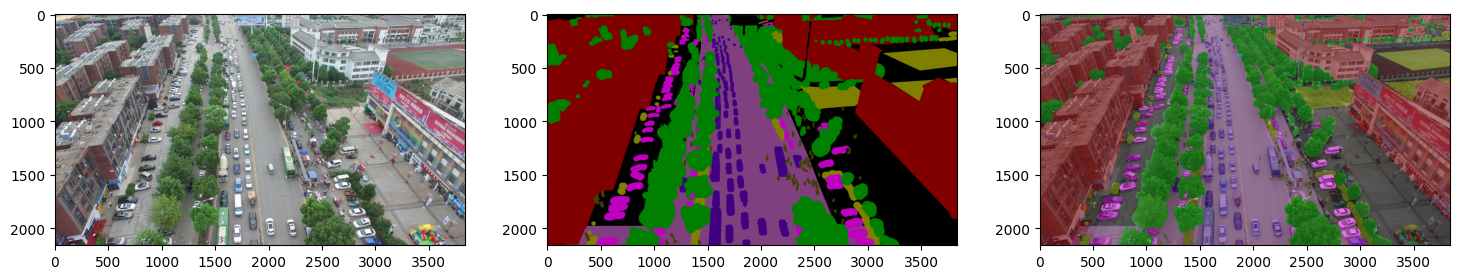

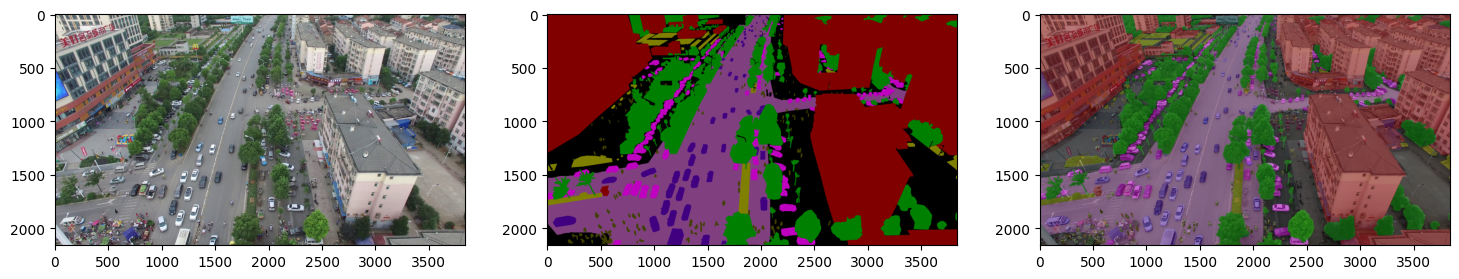

In [6]:
def overlap(image,label,intensity=128):

    label = label.convert("RGBA")

    r, g, b, a = label.split()

    overlay_intensity = intensity
    a = a.point(lambda i: overlay_intensity)

    label = Image.merge("RGBA", (r, g, b, a))

    result = Image.alpha_composite(image.convert("RGBA"), label)

    return result

def viewImage(image_path,label_path):

    if not os.path.exists(image_path):
        logger.error(f'File {image_path} does not exists!!!')

    if not os.path.exists(label_path):
        logger.error(f'File {label_path} does not exists!!!')

    image = Image.open(image_path)
    label = Image.open(label_path)

    plt.figure(figsize=(18, 24))

    plt.subplot(1, 3 , 1)
    plt.imshow(image)

    plt.subplot(1, 3  , 2)
    plt.imshow(label)


    result = overlap(image,label)
    plt.subplot(1, 3  , 3)
    plt.imshow(result)

if VISUALIZE_DATASET_IMAGE_SAMPLE:

    image_path_1 = 'dataset/train/seq1/Images/000000.png'
    label_path_1 = 'dataset/train/seq1/Labels/000000.png'
    viewImage(image_path_1,label_path_1)

    image_path_2 = 'dataset/train/seq1/Images/000600.png'
    label_path_2 = 'dataset/train/seq1/Labels/000600.png'

    viewImage(image_path_2,label_path_2)


In [7]:
# convert 3 channel color code to scalar value

class ColourTransformer:

    def __init__(self):

        self.colour_table = self.get_colour_table()
        self.id_table = self.convert2_id()

    def get_colour_table(self):

        colour_table = {}

        colour_table['Building'] = [128, 0, 0]
        colour_table['Road'] = [128, 64, 128]
        colour_table['Static_Car'] = [192, 0, 192]
        colour_table['Tree'] = [0, 128, 0]
        colour_table['Vegetation'] = [128, 128, 0]
        colour_table['Human'] = [64, 64, 0]
        colour_table['Moving_Car'] = [64, 0, 128]
        colour_table['Clutter'] = [0, 0, 0]

        return colour_table

    def convert2_id(self):

        id_table = {}

        for item in self.colour_table.keys():
            r,g,b = self.colour_table[item]
            id_table[item] = r + g*255 + b*255*255

        return id_table


    def label_transform(self, label, dtype=np.int8):
        label = np.array(Image.open(label))
        height,width = label.shape[:2]

        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*255+id_label[:,:,2]*255*255

        mask = (id_label == self.id_table['Building'])
        newLabel[mask] = 1

        return newLabel

    def enhanced_label_transform(self, label, dtype=np.int8):
        label = np.array(Image.open(label))
        height,width = label.shape[:2]

        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*255+id_label[:,:,2]*255*255

        mask = (id_label == self.id_table['Building'])
        newLabel[mask] = 255

        return newLabel

    def inverse_label_transform(self,label):
        label_img = np.zeros(shape=(label.shape[0], label.shape[1],3),dtype=np.uint8)
        value = self.colour_table['Building']

        mask = (label!=0)
        label_img[mask] = value

        return label_img


In [8]:

def prepare_train_label(path,save_path):

    colour_transformer = ColourTransformer()

    seq_dirs = [x for x in os.listdir(path)]

    for seq_dir in tqdm(seq_dirs):

        dest_seq_path = os.path.join(save_path,seq_dir)
        if not os.path.exists(dest_seq_path ):
            os.mkdir(dest_seq_path)

        labels = [x for x in os.listdir(os.path.join(path,seq_dir,'Labels'))]

        for label in labels:
            label_path = os.path.join(path,seq_dir,'Labels',label)
            new_label = colour_transformer.label_transform(label_path)
            Image.fromarray(new_label).save(os.path.join(dest_seq_path,label))

train_dir = './dataset/train/'
train_save_dir = './dataset/train_label_building'

valid_dir = './dataset/valid/'
valid_save_dir = './dataset/valid_label_building'

if not os.path.exists(train_save_dir ):
            os.mkdir(train_save_dir)

if not os.path.exists(valid_save_dir ):
            os.mkdir(valid_save_dir)

if PREPARE_LABEL:

    prepare_train_label(path=train_dir,save_path=train_save_dir)
    prepare_train_label(path=valid_dir,save_path=valid_save_dir)


In [ ]:

if VISUALIZE_LABEL_TRANSFORM:

    sample_label_path = 'dataset/train/seq1/Labels/000000.png'
    sample_colour_transformer = ColourTransformer()

    original_label_img = Image.open(sample_label_path)

    transformed_label = sample_colour_transformer.label_transform(sample_label_path)
    transformed_label_img = Image.fromarray(sample_colour_transformer.label_transform(sample_label_path))
    enhanced_transformed_label_img = Image.fromarray(sample_colour_transformer.enhanced_label_transform(sample_label_path))

    inverse_transformed_label_img = Image.fromarray(sample_colour_transformer.inverse_label_transform(transformed_label))

    plt.figure(figsize=(18, 24))

    plt.subplot(2, 2 , 1)
    plt.imshow(original_label_img)
    plt.title("Original Label")

    plt.subplot(2, 2  , 2)
    plt.imshow(transformed_label_img)
    plt.title("Transformed Label")
    plt.show()

    plt.figure(figsize=(18, 24))

    plt.subplot(2, 2  , 3)
    plt.imshow(enhanced_transformed_label_img)
    plt.title("Enhanced Transformed Label")

    plt.subplot(2, 2  , 4)
    plt.imshow(inverse_transformed_label_img)
    plt.title("Inverse Transformed Label")

    plt.show()


In [ ]:
if CREATE_TRAIN_LIST:
    train_image_list = sorted(glob.glob(pathname='./dataset/train/*/Images/*.png',recursive=True))
    train_label_list = sorted(glob.glob(pathname='./dataset/train_label_building/*/*.png',recursive=True))

if CREATE_VALID_LIST:
    valid_image_list = sorted(glob.glob(pathname='./dataset/valid/*/Images/*.png',recursive=True))
    valid_label_list = sorted(glob.glob(pathname='./dataset/valid_label_building/*/*.png',recursive=True))

print(train_image_list[0],train_image_list[0])
print(train_image_list[10],train_image_list[10])
print(train_image_list[23],train_image_list[23])


./dataset/train/seq1/Images/000000.png ./dataset/train/seq1/Images/000000.png
./dataset/train/seq10/Images/000000.png ./dataset/train/seq10/Images/000000.png
./dataset/train/seq11/Images/000300.png ./dataset/train/seq11/Images/000300.png


In [9]:
class UAVDataset(Dataset):


    def __init__(self, images_list, labels_list, transform):

        self.images_list = images_list
        self.labels_list = labels_list

        self.image_transform = transform['image']
        self.label_transform = transform['label']


    def __getitem__(self, index):

        image = Image.open(self.images_list[index]).convert("RGB")
        mask = Image.open(self.labels_list[index])

        image = self.image_transform(image)
        mask = self.label_transform(mask)

        mask[mask!=0]=1
        mask = mask.view(IMG_SIZE)

        return image, mask



    def __len__(self):
        return len(self.images_list)

#image transform
image_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

#mask transform
label_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

custom_transform = {
    'image' : image_transform,
    'label' : label_transform
}


In [10]:
def visualize(image, mask, label=None, truth=None,  augment=False, overlay=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Augmented Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")

    elif overlay:
        plt.figure(figsize=(26, 36))
        plt.subplot(1,2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1,2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.show()

        plt.figure(figsize=(26, 36))

        plt.subplot(1,2, 1)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

        plt.subplot(1,2, 2)
        plt.imshow(overlap(image,mask))
        plt.title(f"{'Overlay'}")

    else:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

def visualize_overlay(image, mask, truth_path=None):
    if truth_path is None:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

    else:
        truth = Image.open(truth_path)
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

def visualize_prediction(image, mask):
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

In [11]:

#Dataset Testing


dataset = UAVDataset(train_image_list, train_label_list ,custom_transform)

image, label = dataset[4]
print(image.shape,label.shape)
image , label = transforms.ToPILImage()(image),transforms.ToPILImage()(label)
visualize(
    image=image, mask=label,
    label = 'Output')


NameError: ignored

# MODEL

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="800">


In [14]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

class ConvMixerBlock(nn.Module):
    def __init__(self, dim=1024, depth=7, k=7):
        super(ConvMixerBlock, self).__init__()
        self.block = nn.Sequential(
            *[nn.Sequential(
                Residual(nn.Sequential(
                    # deep wise
                    nn.Conv2d(dim, dim, kernel_size=(k, k), groups=dim, padding=(k // 2, k // 2)),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=(1, 1)),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            ) for i in range(depth)]
        )

    def forward(self, x):
        x = self.block(x)
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):

        super(DoubleConv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],):

        super(UNET, self).__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convMixer = ConvMixerBlock(dim=1024, depth=7, k=7)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )

            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        x = self.convMixer(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


model = UNET().to(DEVICE)
# summary(model, (3, 256, 256))

In [12]:

def save_checkpoint(state,file_name):

    if not os.path.exists('checkpoint_building'):
      os.mkdir('./checkpoint_building')
    print("[*] Saving checkpoint ")
    torch.save(state,f'./checkpoint_building/{file_name}')

def load_checkpoint(model,file_name):

    print("[*] loading checkpoint... ")

    state = torch.load(f'./checkpoint_building/{file_name}')
    model.load_state_dict(state['state_dict'])

def check_accuracy(loader, model ):

    dice_score = torchmetrics.Dice()
    dice_score.to(DEVICE)

    model.eval()

    Dice_total = 0

    scr = 0

    with torch.no_grad():
        for x, y in loader:
            scr+=1

            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            Dice_total += dice_score(preds.int(),y.int())

        print(f"Dice score: {Dice_total/scr}")

    model.train()

In [18]:
#Model CONST

BATCH_SIZE = 5
EPOCH = 10
SHUFFLE = True
LEARNING_RATE = 1e-4

loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

train_dataset = UAVDataset(train_image_list,train_label_list,custom_transform)
valid_dataset = UAVDataset(valid_image_list,valid_label_list,custom_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

NameError: ignored

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

for epoch in range(EPOCH):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(), }

    save_checkpoint(checkpoint,f"model_{epoch+1}.pth.tar")

    check_accuracy(valid_loader,model)


100%|██████████| 40/40 [06:13<00:00,  9.35s/it, loss=0.393]


[*] Saving checkpoint 
Dice score: 0.6575149893760681


100%|██████████| 40/40 [01:36<00:00,  2.42s/it, loss=0.333]


[*] Saving checkpoint 
Dice score: 0.839469850063324


100%|██████████| 40/40 [01:39<00:00,  2.48s/it, loss=0.278]


[*] Saving checkpoint 
Dice score: 0.8615411520004272


100%|██████████| 40/40 [01:36<00:00,  2.41s/it, loss=0.298]


[*] Saving checkpoint 
Dice score: 0.8667260408401489


100%|██████████| 40/40 [01:38<00:00,  2.47s/it, loss=0.251]


[*] Saving checkpoint 
Dice score: 0.8622710108757019


100%|██████████| 40/40 [01:37<00:00,  2.45s/it, loss=0.369]


[*] Saving checkpoint 
Dice score: 0.8570195436477661


100%|██████████| 40/40 [01:37<00:00,  2.45s/it, loss=0.233]


[*] Saving checkpoint 
Dice score: 0.8767731785774231


100%|██████████| 40/40 [01:39<00:00,  2.48s/it, loss=0.24]


[*] Saving checkpoint 
Dice score: 0.8784518837928772


100%|██████████| 40/40 [01:37<00:00,  2.44s/it, loss=0.165]


[*] Saving checkpoint 
Dice score: 0.871743381023407


100%|██████████| 40/40 [01:38<00:00,  2.47s/it, loss=0.199]


[*] Saving checkpoint 
Dice score: 0.8810223340988159


[*] loading checkpoint... 


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


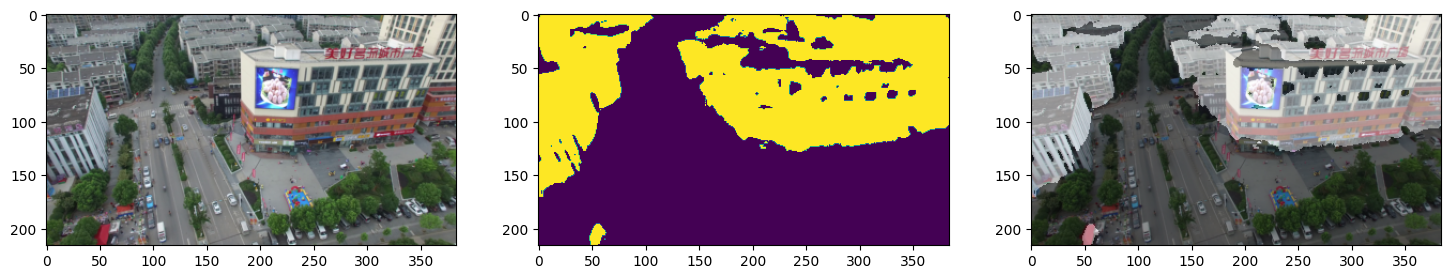

In [16]:
#testing with a single image

def predict(image,model):
  model.eval()

  input_img = Image.open(image)
  image = Image.open(image).convert("RGB")
  image = image_transform(image).to(DEVICE)
  image = image.unsqueeze(0)

  with torch.no_grad():
      preds = torch.sigmoid(model(image))
      preds = (preds > 0.5).float()

      to_pil = transforms.ToPILImage()
      pred = to_pil(preds[0])

      image = transforms.ToPILImage()(image.squeeze(0))

      plt.figure(figsize=(18, 24))

      plt.subplot(1, 3 , 1)
      plt.imshow(image)

      plt.subplot(1, 3  , 2)
      plt.imshow(pred)

      plt.subplot(1, 3  , 3)
      plt.imshow(overlap(image,pred,100))

  model.train()

load_checkpoint(model,"model_10.pth.tar")

test_img_path = './dataset/valid/seq16/Images/000000.png'

predict(test_img_path,model)

In [17]:
test_image_count = 10

count = 0

for idx, (x, y) in enumerate(valid_loader):

    x = x.to(DEVICE)

    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()

        size = len(preds)

        for i in range(size):
          image = transforms.ToPILImage()(x[i])
          truth = transforms.ToPILImage()(y[i])
          pred = transforms.ToPILImage()(preds[i])

          visualize(image=image, mask=pred, truth=truth, overlay=False)

    break


NameError: ignored